In [1]:
!pip install optuna
!pip install pytorch-lightning
!pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 12.7 MB/s 
     |████████████████████████████████| 81 kB 9.8 MB/s 
     |████████████████████████████████| 209 kB 56.0 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 146 kB 67.1 MB/s 
     |████████████████████████████████| 112 kB 57.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=cce0482620b6f334e9de0f781e30fe41ad0f45c059d032e908129edac10d9014
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 12.1 MB/s 
     |████████████████████████████████| 596 kB 55.9 

In [2]:
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import optuna

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from sklearn.preprocessing import MinMaxScaler


import torch
import torch.nn.functional as F
from torch import distributions

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.data.examples import generate_ar_data

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, NormalDistributionLoss, LogNormalDistributionLoss, BaseEstimator
from pytorch_forecasting.data.encoders import GroupNormalizer
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

warnings.filterwarnings('ignore')
%matplotlib inline

logger = TensorBoardLogger('.', name = 'TFT')

from datetime import datetime

save_path = '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/'
datetime.today()
today = datetime.today()
str_today = today.strftime('%y%m%d%H%M')
save_model = save_path + str_today + '_TFT_key_saved_model.pth'
save_best_model = save_path + str_today + '_TFT_key_saved_best_model.pth'
print(save_model)
print(save_best_model)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


/content/drive/MyDrive/Colab Notebooks/실무인증/Data/2206220240_TFT_key_saved_model.pth
/content/drive/MyDrive/Colab Notebooks/실무인증/Data/2206220240_TFT_key_saved_best_model.pth


In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_pca_v2.pickle', 'rb') as f:
    data = pickle.load(f)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707 entries, 0 to 1706
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1707 non-null   datetime64[ns]
 1   market                1707 non-null   object        
 2   principal component1  1707 non-null   float64       
 3   principal component2  1707 non-null   float64       
 4   kr_holiday            1707 non-null   object        
 5   us_holiday            1707 non-null   object        
 6   dayofweek             1707 non-null   category      
 7   month                 1707 non-null   category      
 8   dominant_topic        1707 non-null   category      
 9   trade_price_log       1707 non-null   float64       
 10  trade_price           1707 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(4), object(3)
memory usage: 112.1+ KB


In [4]:


# drop_col = ['dominant_topic']
# data_t = data.drop(drop_col, axis=1)
# # data['keyword'] = data['keyword'].str.replace("<"," ")
data_t = data.copy()
data_t['date'] = pd.to_datetime(data_t['date'], format='%Y-%m-%d')
data_t = data_t.sort_values('date').reset_index(drop=True)
data_t['time_index'] = np.arange(len(data))
data_t['time_index'] = data_t['time_index'].astype(int)
data_t['market'] = data_t['market'].astype(str).astype("category")


data_t['kr_holiday'] = data_t['kr_holiday'].apply(lambda x : x.replace('.',''))

holi_df = pd.get_dummies(data_t['kr_holiday'])
holi_df = holi_df.drop(columns='-')
kr_special_days = holi_df.columns.tolist()

holi_df[kr_special_days] = (
    holi_df[kr_special_days]
    .apply(lambda x: x.map({0: "-", 1: x.name}))
    .astype("category")
)


res_data = pd.concat([data_t.drop(columns = ['us_holiday','kr_holiday']), holi_df], axis=1)

In [5]:
res_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1707 entries, 0 to 1706
Data columns (total 31 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   date                                                   1707 non-null   datetime64[ns]
 1   market                                                 1707 non-null   category      
 2   principal component1                                   1707 non-null   float64       
 3   principal component2                                   1707 non-null   float64       
 4   dayofweek                                              1707 non-null   category      
 5   month                                                  1707 non-null   category      
 6   dominant_topic                                         1707 non-null   category      
 7   trade_price_log                                        1707 non-null 

In [6]:
def objective(trial):

    cfg = { 'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 1e-0),
            'hidden_size' : trial.suggest_categorical('hidden_size', [16,32, 64,128,256,512,1024]),
            'hidden_continuous_size' : trial.suggest_categorical('hidden_continuous_size', [16,32,64,128,256,512,1024]),
            'attention_head_size' : trial.suggest_int('attention_head_size', 2, 7, 1),
            'gradient_clip_val' : trial.suggest_loguniform('gradient_clip_val', 1e-4, 1e-0),
             'dropout' : trial.suggest_categorical('dropout', [0,0.1,0.2])
        }

    torch.manual_seed(42) 

    # create dataset and dataloader
    max_encoder_length = 60
    max_prediction_length = 20

    output_size = 7
    log_interval = 10
    limit_train_batches = 50
    batch_size = 128
    gpus = 1
    max_epochs = 50
    reduce_on_plateau_patience = 4


    training_cutoff = res_data['time_index'].max() - max_prediction_length


    training = TimeSeriesDataSet(
            res_data[lambda x: x.time_index <= training_cutoff],
            time_idx="time_index",
            target="trade_price",
            group_ids=["market"], # ["agency", "sku"],
            min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            static_categoricals=["market"], # ["agency", "sku"],
            static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
            time_varying_known_categoricals=["dayofweek", "month","kr_special_days","dominant_topic"], #'kr_holiday','us_holiday'], #["special_days", "month"],
            variable_groups= {"kr_special_days" : kr_special_days},  # group of categorical variables can be treated as one variable
            time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
            time_varying_unknown_categoricals=[],     
            time_varying_unknown_reals=[
                    "trade_price",                        
                    # "trade_price_log",
                    'principal component1',
                    'principal component2'
            ],
            target_normalizer=GroupNormalizer(
                groups=["market"], transformation="softplus"
            ), 
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
        )

    validation = TimeSeriesDataSet.from_dataset(
            training,
            res_data,
            min_prediction_idx = training_cutoff + 1,
            predict=True,
            stop_randomization=True
        )

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
    actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
    baseline_predictions = Baseline().predict(val_dataloader)
    mae_with_baseline = (actuals - baseline_predictions).abs().mean().item()

    print(f'mae_with_baseline : {mae_with_baseline}')
    print(f'Baseline SMAPE : {SMAPE()(baseline_predictions, actuals)}')


    TFT = TemporalFusionTransformer.from_dataset(
        training,
        # architecture hyperparameters
        learning_rate = cfg['learning_rate'],
        hidden_size = cfg['hidden_size'],
        hidden_continuous_size = cfg['hidden_continuous_size'],
        dropout = cfg['dropout'],
        attention_head_size = cfg['attention_head_size'],
        output_size = output_size,  # 7 quantiles by default
        loss = QuantileLoss(),
        log_interval = log_interval,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
        reduce_on_plateau_patience = reduce_on_plateau_patience,
    )


    # configure network and trainer
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate


    trainer = pl.Trainer(
        max_epochs = max_epochs,
        gpus = gpus,
        weights_summary = 'top',
        gradient_clip_val = cfg['gradient_clip_val'],
        callbacks = [lr_logger, early_stop_callback],
        limit_train_batches =  limit_train_batches, # coment in for training, running valiation every 30 batches
        # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
        enable_checkpointing = True,
        auto_lr_find = True,
        logger=logger
    )
        

    print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

    # fit network
    trainer.fit(
        TFT,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )



    #### Evaluate performance

    # load the best model according to the validation loss
    # (given that we use early stopping, this is not necessarily the last epoch)
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    torch.save(best_model.state_dict(), save_model)

    actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
    predictions = best_model.predict(val_dataloader)

    return SMAPE()(predictions, actuals)

In [7]:
sampler = optuna.samplers.TPESampler()

study = optuna.create_study(sampler=sampler, direction='minimize') 
study.optimize(objective, n_trials=25)

[I 2022-06-22 02:41:09,053] A new study created in memory with name: no-name-a3c8cbe5-c715-4ca2-a888-4913fac8257d


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./TFT


Number of parameters in network: 6605.1k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 8.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 1.0 M 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 673 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 263 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 263 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 02:43:37,579] Trial 0 finished with value: 0.37024784088134766 and parameters: {'learning_rate': 0.00017647911820304512, 'hidden_size': 256, 'hidden_continuous_size': 512, 'attention_head_size': 6, 'gradient_clip_val': 0.9584533454377681, 'dropout': 0}. Best is trial 0 with value: 0.37024784088134766.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 150.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 02:47:09,729] Trial 1 finished with value: 0.3389114737510681 and parameters: {'learning_rate': 0.003700965165670177, 'hidden_size': 16, 'hidden_continuous_size': 512, 'attention_head_size': 4, 'gradient_clip_val': 0.00031830769319468344, 'dropout': 0.1}. Best is trial 1 with value: 0.3389114737510681.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                     

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 296.3k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 02:49:21,537] Trial 2 finished with value: 0.25797638297080994 and parameters: {'learning_rate': 0.8479258802412142, 'hidden_size': 32, 'hidden_continuous_size': 512, 'attention_head_size': 7, 'gradient_clip_val': 0.0007003720788186136, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 141.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 02:50:47,145] Trial 3 finished with value: 0.3804763853549957 and parameters: {'learning_rate': 0.06172827317563067, 'hidden_size': 32, 'hidden_continuous_size': 128, 'attention_head_size': 2, 'gradient_clip_val': 0.0013057922415945099, 'dropout': 0.1}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 101.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 02:52:11,722] Trial 4 finished with value: 0.3903568387031555 and parameters: {'learning_rate': 0.0055888159689525254, 'hidden_size': 32, 'hidden_continuous_size': 32, 'attention_head_size': 3, 'gradient_clip_val': 0.04424009250787092, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 4

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 1675.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 02:53:46,144] Trial 5 finished with value: 0.4591105878353119 and parameters: {'learning_rate': 0.7010175325766366, 'hidden_size': 128, 'hidden_continuous_size': 256, 'attention_head_size': 7, 'gradient_clip_val': 0.03710923320221565, 'dropout': 0.2}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 383.7k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 02:58:26,343] Trial 6 finished with value: 0.4529404044151306 and parameters: {'learning_rate': 0.0003530962803343622, 'hidden_size': 64, 'hidden_continuous_size': 64, 'attention_head_size': 5, 'gradient_clip_val': 0.00022055366181654012, 'dropout': 0.1}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 4289.4k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 2.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 304 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 514 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 207 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 263 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 263 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 263 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:00:07,496] Trial 7 finished with value: 0.4318743646144867 and parameters: {'learning_rate': 0.0134090994833501, 'hidden_size': 256, 'hidden_continuous_size': 128, 'attention_head_size': 4, 'gradient_clip_val': 0.05658615877919033, 'dropout': 0.1}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 5943.9k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 4.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 796 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.3 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 536 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 263 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 263 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:02:06,299] Trial 8 finished with value: 0.5180231332778931 and parameters: {'learning_rate': 0.2514129518462248, 'hidden_size': 256, 'hidden_continuous_size': 256, 'attention_head_size': 3, 'gradient_clip_val': 0.0023666115182068557, 'dropout': 0.1}. Best is trial 2 with value: 0.25797638297080994.


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 1.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 443 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 758 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 312 K 
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 53310.7k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:07:23,012] Trial 9 finished with value: 0.5190207362174988 and parameters: {'learning_rate': 0.0009766103935563838, 'hidden_size': 1024, 'hidden_continuous_size': 64, 'attention_head_size': 6, 'gradient_clip_val': 0.0010051840743111708, 'dropout': 0.2}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                   

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 503.7k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:08:47,979] Trial 10 finished with value: 0.32338064908981323 and parameters: {'learning_rate': 0.059295012493664055, 'hidden_size': 32, 'hidden_continuous_size': 1024, 'attention_head_size': 7, 'gradient_clip_val': 0.010992781138003414, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                     

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 503.7k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:10:19,730] Trial 11 finished with value: 0.3465671241283417 and parameters: {'learning_rate': 0.11246912551250014, 'hidden_size': 32, 'hidden_continuous_size': 1024, 'attention_head_size': 7, 'gradient_clip_val': 0.005666840193415966, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 16.4 K
4  | static_variable_selection          | VariableSelectionNetwork        | 4.0 M 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.6 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 M 
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 26230.8k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:12:57,785] Trial 12 finished with value: 0.9225894212722778 and parameters: {'learning_rate': 0.9667637887601858, 'hidden_size': 512, 'hidden_continuous_size': 1024, 'attention_head_size': 6, 'gradient_clip_val': 0.012118274718024737, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      |

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 74.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:15:16,774] Trial 13 finished with value: 0.4184938967227936 and parameters: {'learning_rate': 0.037204277867274614, 'hidden_size': 32, 'hidden_continuous_size': 16, 'attention_head_size': 7, 'gradient_clip_val': 0.00010841766344441699, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 503.9k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:17:21,013] Trial 14 finished with value: 0.36763232946395874 and parameters: {'learning_rate': 0.23570764691580098, 'hidden_size': 32, 'hidden_continuous_size': 1024, 'attention_head_size': 5, 'gradient_clip_val': 0.2640126243021378, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 150.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:18:57,653] Trial 15 finished with value: 0.3560032248497009 and parameters: {'learning_rate': 0.02185100586163837, 'hidden_size': 16, 'hidden_continuous_size': 512, 'attention_head_size': 7, 'gradient_clip_val': 0.006867238162042801, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 938.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:20:11,045] Trial 16 finished with value: 0.375177800655365 and parameters: {'learning_rate': 0.27318098867956764, 'hidden_size': 128, 'hidden_continuous_size': 32, 'attention_head_size': 6, 'gradient_clip_val': 0.0008075958444630735, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params 
-----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      
1  | logging_metrics                    | ModuleList                      | 0      
2  | input_embeddings                   | MultiEmbedding                  | 486    
3  | prescalers                         | ModuleDict                      | 256    
4  | static_variable_selection          | VariableSelectionNetwork        | 124 K  
5  | encoder_variable_selection         | VariableSelectionNetwork        | 225 K  
6  | decoder_variable_selection         | VariableSelectionNetwork        | 100.0 K
7  | static_context_variable_selection  | GatedRes

Number of parameters in network: 52315.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:23:40,417] Trial 17 finished with value: 0.5217543840408325 and parameters: {'learning_rate': 0.09092439763873193, 'hidden_size': 1024, 'hidden_continuous_size': 16, 'attention_head_size': 5, 'gradient_clip_val': 0.016721354380062517, 'dropout': 0.2}. Best is trial 2 with value: 0.25797638297080994.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                     

mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459
Number of parameters in network: 1081.6k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:25:39,509] Trial 18 finished with value: 0.36193978786468506 and parameters: {'learning_rate': 0.0027729892094721697, 'hidden_size': 64, 'hidden_continuous_size': 1024, 'attention_head_size': 7, 'gradient_clip_val': 0.004575619664327922, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 8.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 3.2 M 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.3 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.1 M 
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 23550.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:32:27,308] Trial 19 finished with value: 0.3087409734725952 and parameters: {'learning_rate': 0.4619149523749281, 'hidden_size': 512, 'hidden_continuous_size': 512, 'attention_head_size': 6, 'gradient_clip_val': 0.1412440160167027, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 8.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 3.2 M 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.3 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.1 M 
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 23550.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:36:28,684] Trial 20 finished with value: 0.44678840041160583 and parameters: {'learning_rate': 0.5262246525348776, 'hidden_size': 512, 'hidden_continuous_size': 512, 'attention_head_size': 6, 'gradient_clip_val': 0.17996981282584582, 'dropout': 0.2}. Best is trial 2 with value: 0.25797638297080994.


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 8.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 3.2 M 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.3 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.1 M 
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 23539.2k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:38:46,255] Trial 21 finished with value: 0.2875264585018158 and parameters: {'learning_rate': 0.16103370267733266, 'hidden_size': 512, 'hidden_continuous_size': 512, 'attention_head_size': 7, 'gradient_clip_val': 0.14740852551806394, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 8.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 3.2 M 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.3 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.1 M 
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 23550.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:44:16,373] Trial 22 finished with value: 0.3559826910495758 and parameters: {'learning_rate': 0.3434711976425696, 'hidden_size': 512, 'hidden_continuous_size': 512, 'attention_head_size': 6, 'gradient_clip_val': 0.15398045254615864, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 8.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 3.2 M 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.3 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.1 M 
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 23539.2k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:46:42,411] Trial 23 finished with value: 0.5149949193000793 and parameters: {'learning_rate': 0.13310271742948712, 'hidden_size': 512, 'hidden_continuous_size': 512, 'attention_head_size': 7, 'gradient_clip_val': 0.09523408592890126, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.


mae_with_baseline : 690900.0
Baseline SMAPE : 0.2359931915998459


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 8.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 3.2 M 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.3 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.1 M 
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 23550.5k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-06-22 03:48:30,900] Trial 24 finished with value: 2.0 and parameters: {'learning_rate': 0.899414761041835, 'hidden_size': 512, 'hidden_continuous_size': 512, 'attention_head_size': 6, 'gradient_clip_val': 0.26411540578532355, 'dropout': 0}. Best is trial 2 with value: 0.25797638297080994.


In [8]:
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_pca_220622_01.pkl')

['/content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_pca_220622_01.pkl']

In [ ]:
study = joblib.load("/content/drive/MyDrive/Colab Notebooks/실무인증/Data/tft_optuna_pca_220622_01.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

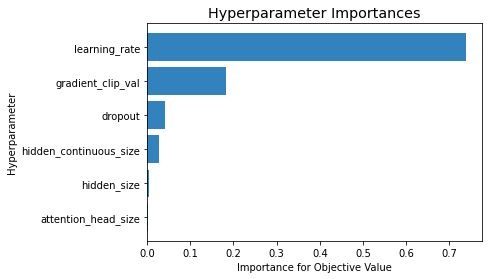

In [9]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

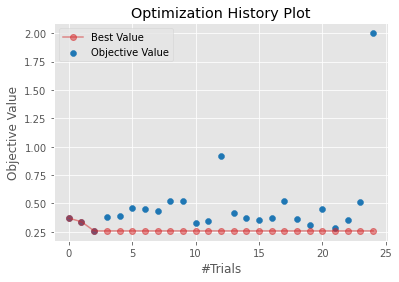



Number of finished trials:  25
Best trial:
  Value:  0.25797638297080994
  Params: 
    learning_rate: 0.8479258802412142
    hidden_size: 32
    hidden_continuous_size: 512
    attention_head_size: 7
    gradient_clip_val: 0.0007003720788186136
    dropout: 0


In [10]:
# show best hyperparameters
# print(study.best_trial.params)
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()
print("\n")


print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [22]:
torch.manual_seed(42) 

# create dataset and dataloader
max_encoder_length = 60
max_prediction_length = 20

output_size = 7
log_interval = 10
limit_train_batches = 50
batch_size = 128
gpus = 1
max_epochs = 30
reduce_on_plateau_patience = 4


training_cutoff = res_data['time_index'].max() - max_prediction_length


training = TimeSeriesDataSet(
        res_data[lambda x: x.time_index <= training_cutoff],
        time_idx="time_index",
        target="trade_price",
        group_ids=["market"], # ["agency", "sku"],
        min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        static_categoricals=["market"], # ["agency", "sku"],
        static_reals=[], #["avg_population_2017", "avg_yearly_household_income_2017"],
        time_varying_known_categoricals=["dayofweek", "month","kr_special_days","dominant_topic"], #'kr_holiday','us_holiday'], #["special_days", "month"],
        variable_groups= {"kr_special_days" : kr_special_days},  # group of categorical variables can be treated as one variable
        time_varying_known_reals=["time_index"], # ["time_index", "price_regular", "discount_in_percent"],
        time_varying_unknown_categoricals=[],     
        time_varying_unknown_reals=[
            "trade_price",                        
            # "trade_price_log",
            'principal component1',
            'principal component2'
        ],
        target_normalizer=GroupNormalizer(
            groups=["market"], transformation="softplus"
        ), 
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
    )

validation = TimeSeriesDataSet.from_dataset(
        training,
        res_data,
        min_prediction_idx = training_cutoff + 1,
        predict=True,
        stop_randomization=True
    )

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


TFT = TemporalFusionTransformer.from_dataset(
    training,
    # architecture hyperparameters
    learning_rate = study.best_params['learning_rate'],
    hidden_size = study.best_params['hidden_size'],
    hidden_continuous_size = study.best_params['hidden_continuous_size'],
    dropout = study.best_params['dropout'],
    attention_head_size = study.best_params['attention_head_size'],
    output_size = output_size,  # 7 quantiles by default
    loss = QuantileLoss(),
    log_interval = log_interval,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience = reduce_on_plateau_patience,
)


# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate


trainer = pl.Trainer(
    max_epochs = max_epochs,
    gpus = gpus,
    weights_summary = 'top',
    gradient_clip_val = study.best_params['gradient_clip_val'],
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches =  limit_train_batches, # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    enable_checkpointing = True,
    auto_lr_find = True,
    logger=TensorBoardLogger('.', name = 'best_tft')
)
    

print(f"Number of parameters in network: {TFT.size()/1e3:.1f}k")

# fit network
trainer.fit(
    TFT,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


#### Evaluate performance

# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

torch.save(best_model.state_dict(), save_best_model )

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions, _ = best_model.predict(val_dataloader, return_x=True)
# predictions = best_model.predict(val_dataloader)

SMAPE = (2 * (predictions - actuals).abs() / (predictions.abs() + actuals.abs() + 1e-8)).mean()
print(f'SMAPE : {SMAPE}')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 486   
3  | prescalers                         | ModuleDict                      | 8.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 68.6 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 128 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 48.6 K
7  | static_context_variable_selection  | GatedResidualNetw

Number of parameters in network: 296.3k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

SMAPE : 0.23804351687431335


In [12]:
actuals

tensor([[3038000., 3095000., 2884000., 2648000., 2694000., 2733000., 2806000.,
         2660000., 2695000., 2472000., 2583000., 2538000., 2552000., 2627000.,
         2533000., 2525000., 2494000., 2314000., 2225000., 2286000.]])

In [21]:
predictions

tensor([[3324487.2500, 3381535.2500, 3370614.5000, 3247624.7500, 3307008.0000,
         3321316.0000, 3325103.2500, 3319565.2500, 3338078.5000, 3310153.2500,
         3265231.7500, 3317762.5000, 3327154.0000, 3328802.5000, 3320914.0000,
         3338106.7500, 3309293.5000, 3264405.2500, 3316605.5000, 3325152.5000]])

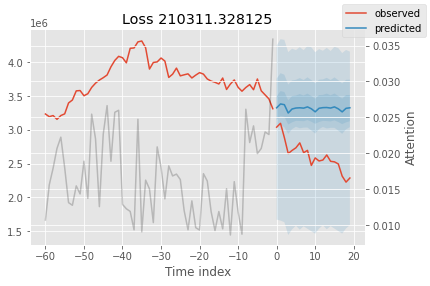

In [14]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

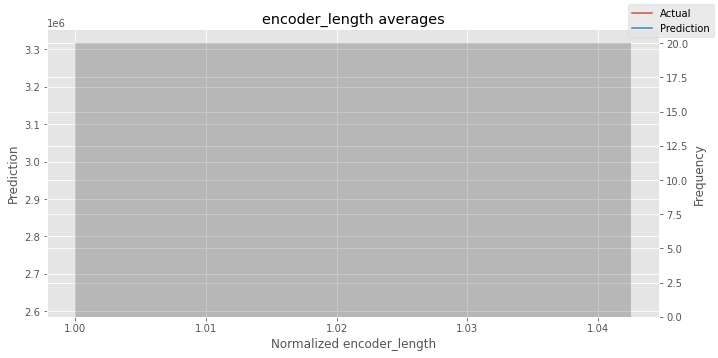

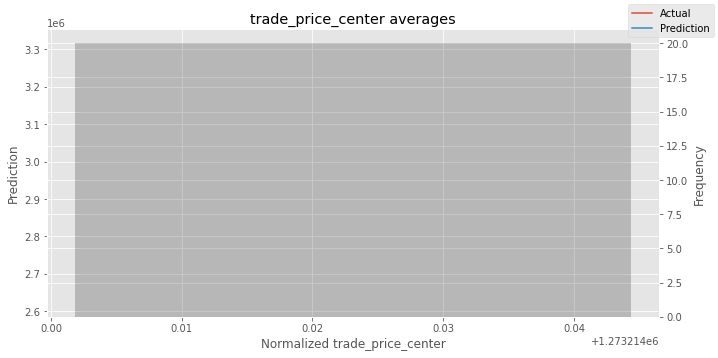

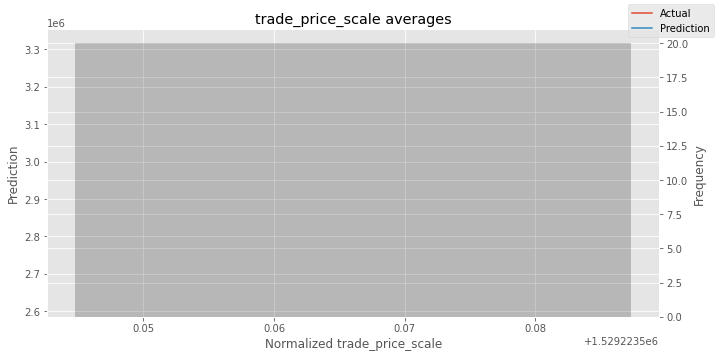

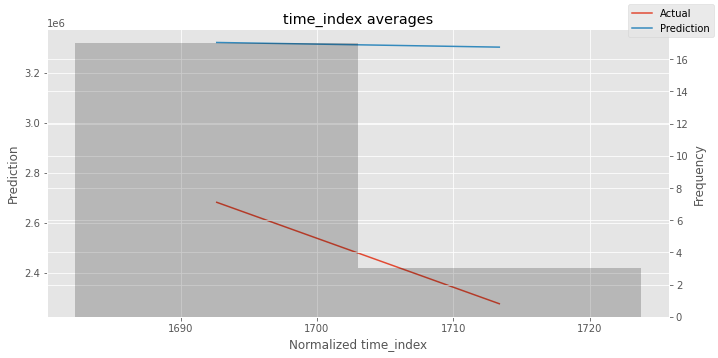

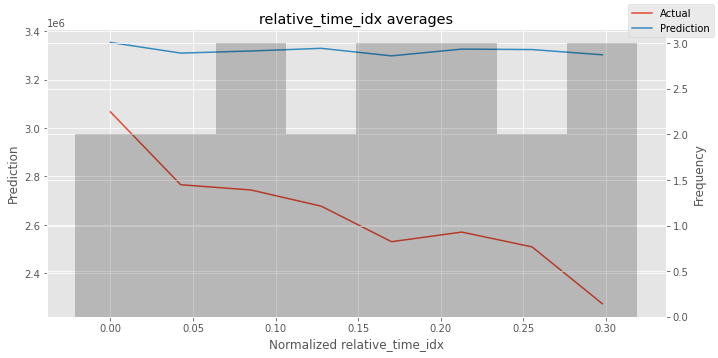

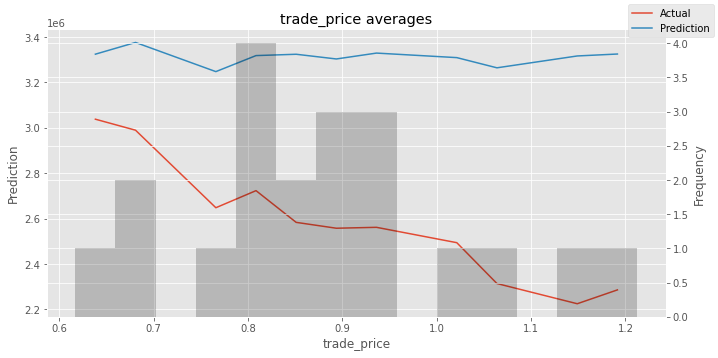

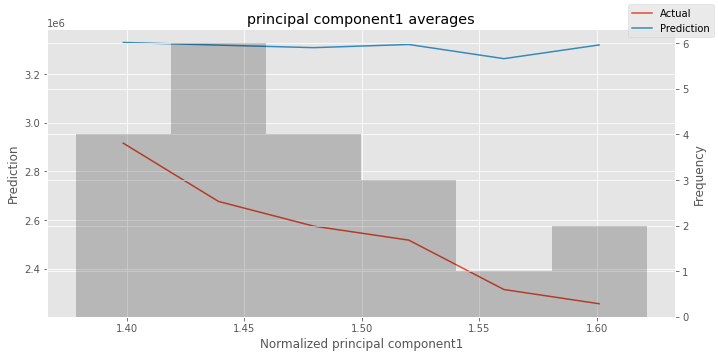

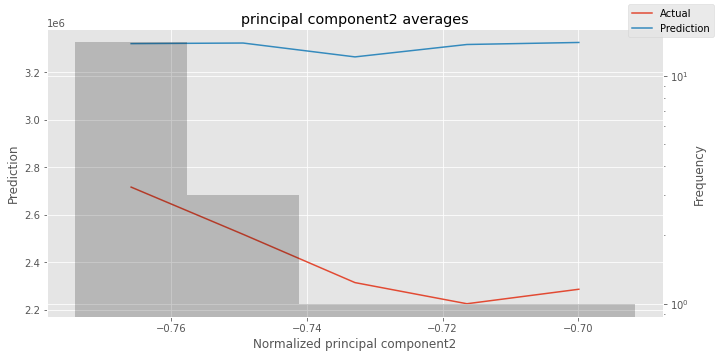

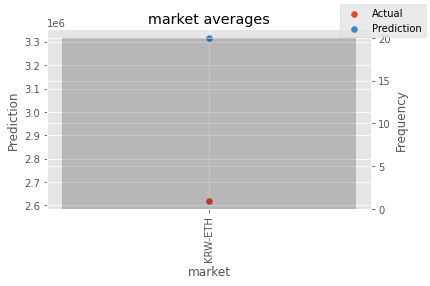

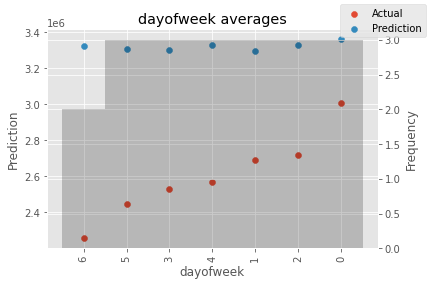

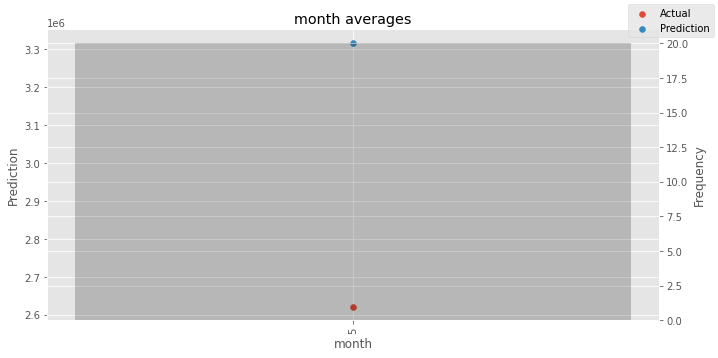

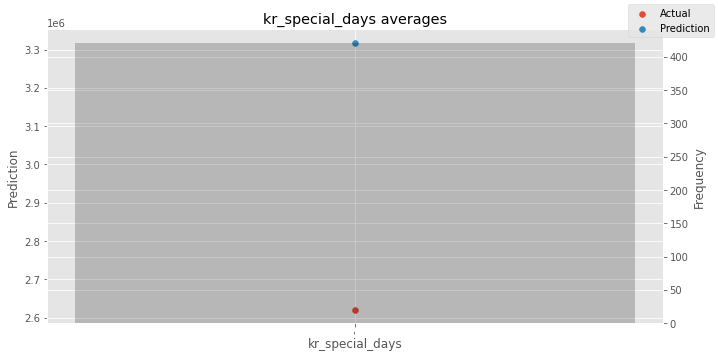

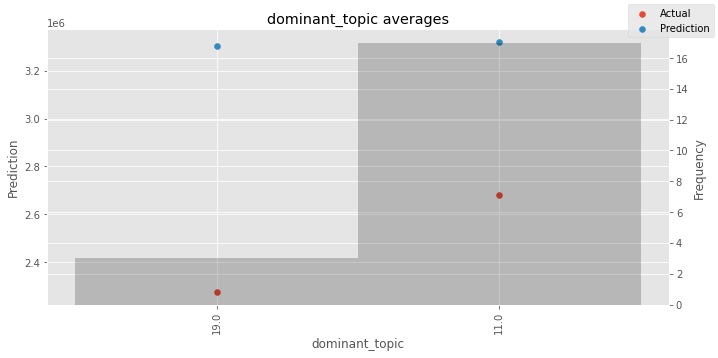

In [15]:
predictions, x = best_model.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_model.calculate_prediction_actual_by_variable(x, predictions)
best_model.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>,
 'encoder_variables': <Figure size 504x306 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>}

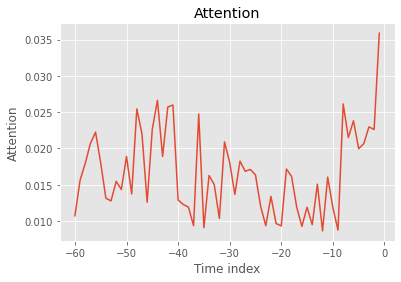

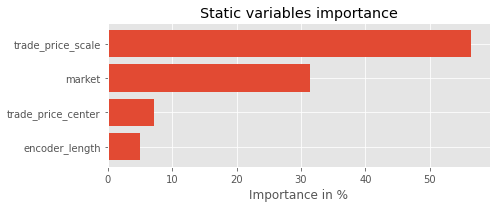

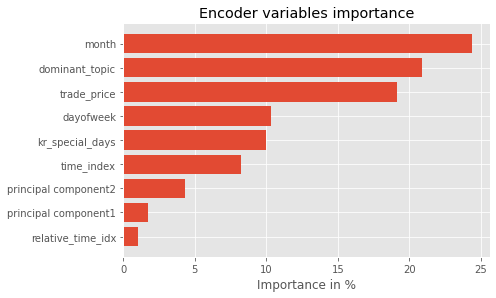

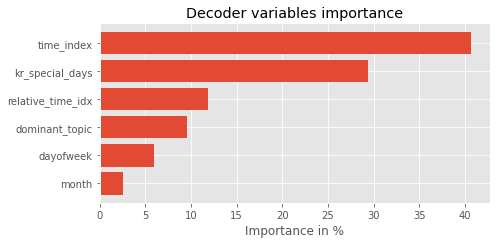

In [16]:
interpretation = best_model.interpret_output(raw_predictions, reduction="sum")
best_model.plot_interpretation(interpretation)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

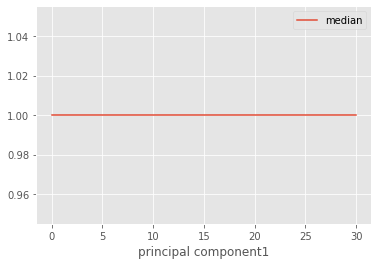

In [18]:
dependency = best_model.predict_dependency(
    val_dataloader.dataset, "principal component1", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("principal component1").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);

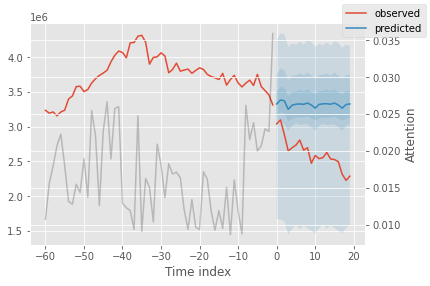

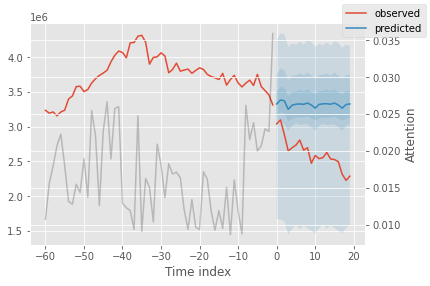

In [19]:
def plot_prediction(
    self,
    x: Dict[str, torch.Tensor],
    out: Dict[str, torch.Tensor],
    idx: int,
    plot_attention: bool = True,
    add_loss_to_title: bool = False,
    show_future_observed: bool = True,
    ax=None,
) -> plt.Figure:
    """
    Plot actuals vs prediction and attention

    Args:
        x (Dict[str, torch.Tensor]): network input
        out (Dict[str, torch.Tensor]): network output
        idx (int): sample index
        plot_attention: if to plot attention on secondary axis
        add_loss_to_title: if to add loss to title. Default to False.
        show_future_observed: if to show actuals for future. Defaults to True.
        ax: matplotlib axes to plot on

    Returns:
        plt.Figure: matplotlib figure
    """
    # plot prediction as normal
    fig = best_model.plot_prediction(
        x, out, idx=idx, add_loss_to_title=add_loss_to_title, show_future_observed=show_future_observed, ax=ax
    )

    # add attention on secondary axis
    if plot_attention:
        interpretation = self.interpret_output(out)
        ax = fig.axes[0]
        ax2 = ax.twinx()
        ax2.set_ylabel("Attention")
        encoder_length = x["encoder_lengths"][idx]
        ax2.plot(
            torch.arange(-encoder_length, 0),
            interpretation["attention"][idx, :encoder_length].detach().cpu(),
            alpha=0.2,
            color="k",
        )
    fig.tight_layout()
    return fig

raw_predictions, x = best_model.predict(val_dataloader, mode = 'raw', return_x=True)

best_model.plot_prediction( x=x,
    out=raw_predictions,
    idx=0)